# Training Generative Adversarial Networks (GANs) in PyTorch



# Introduction to Generative Modeling

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)


<img src="https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png" style="width:480px; margin-bottom:32px"/>

In [1]:
project_name = '06b-anime-dcgan'

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

100%|███████████████████████████████████████████████████████████████████████████████| 395M/395M [00:16<00:00, 25.4MB/s]


The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [4]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [5]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

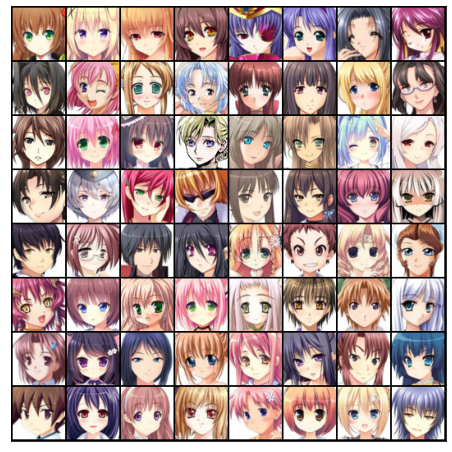

In [12]:
show_batch(train_dl)

In [13]:
!pip install jovian --upgrade --quiet

In [14]:
import jovian

In [15]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Creating a new project "gopirevathisreenivasan/06b-anime-dcgan"
[jovian] Committed successfully! https://jovian.ai/gopirevathisreenivasan/06b-anime-dcgan


'https://jovian.ai/gopirevathisreenivasan/06b-anime-dcgan'

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)

In [19]:
import torch.nn as nn

In [20]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [21]:
discriminator = to_device(discriminator, device)

In [22]:
latent_size = 128

In [23]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


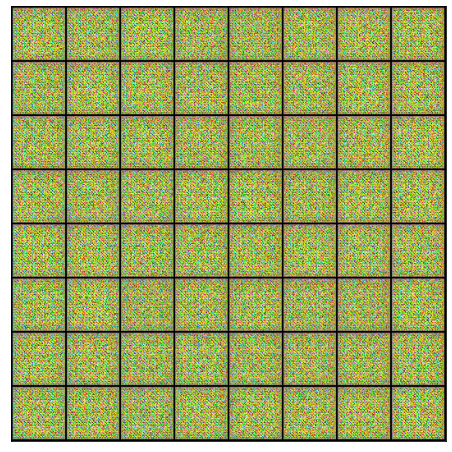

In [24]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [25]:
generator = to_device(generator, device)

In [26]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [27]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [28]:
from torchvision.utils import save_image

In [29]:
sample_dir = 'generated_anime'
os.makedirs(sample_dir, exist_ok=True)

In [30]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [31]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


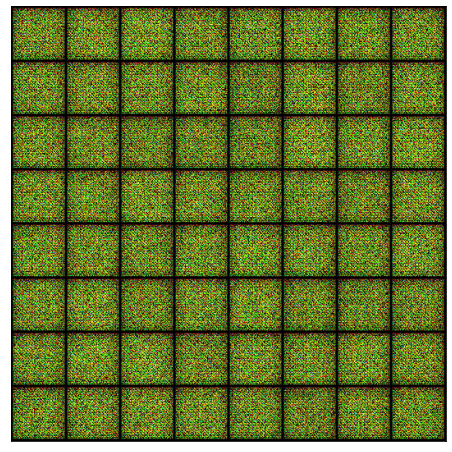

In [32]:
save_samples(0, fixed_latent)

In [33]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "gopirevathisreenivasan/06b-anime-dcgan" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/gopirevathisreenivasan/06b-anime-dcgan


'https://jovian.ai/gopirevathisreenivasan/06b-anime-dcgan'

In [34]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [36]:
lr = 0.0002
epochs = 25

In [37]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [38]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 8.8731, loss_d: 1.4144, real_score: 0.8577, fake_score: 0.6316
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.2267, loss_d: 0.7719, real_score: 0.7355, fake_score: 0.3066
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.8135, loss_d: 0.1711, real_score: 0.8934, fake_score: 0.0300
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.1074, loss_d: 0.1935, real_score: 0.8996, fake_score: 0.0730
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 8.2971, loss_d: 0.4339, real_score: 0.9068, fake_score: 0.2543
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.8401, loss_d: 0.2002, real_score: 0.9888, fake_score: 0.1544
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 5.1630, loss_d: 0.1393, real_score: 0.9449, fake_score: 0.0660
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.5191, loss_d: 0.0877, real_score: 0.9613, fake_score: 0.0388
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.8512, loss_d: 0.1699, real_score: 0.9131, fake_score: 0.0411
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.6923, loss_d: 0.0481, real_score: 0.9822, fake_score: 0.0275
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 6.6230, loss_d: 0.0568, real_score: 0.9712, fake_score: 0.0212
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 6.7299, loss_d: 0.0300, real_score: 0.9873, fake_score: 0.0160
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.3749, loss_d: 0.0654, real_score: 0.9894, fake_score: 0.0519
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 8.3846, loss_d: 0.1673, real_score: 0.9638, fake_score: 0.1047
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 13.5301, loss_d: 0.0416, real_score: 0.9697, fake_score: 0.0057
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 7.2557, loss_d: 0.1213, real_score: 0.9659, fake_score: 0.0747
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 7.0856, loss_d: 0.1109, real_score: 0.9224, fake_score: 0.0097
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.7943, loss_d: 0.0131, real_score: 0.9970, fake_score: 0.0099
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 6.8113, loss_d: 0.0446, real_score: 0.9760, fake_score: 0.0154
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 5.1595, loss_d: 1.8237, real_score: 0.3527, fake_score: 0.0000
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 14.4457, loss_d: 0.0354, real_score: 0.9738, fake_score: 0.0006
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.3658, loss_d: 0.0352, real_score: 0.9833, fake_score: 0.0165
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 15.4573, loss_d: 0.0702, real_score: 0.9549, fake_score: 0.0046
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 6.8456, loss_d: 0.4833, real_score: 0.7260, fake_score: 0.0000
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 7.8888, loss_d: 0.0987, real_score: 0.9578, fake_score: 0.0463
Saving generated-images-0025.png


In [39]:
losses_g, losses_d, real_scores, fake_scores = history

In [40]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [41]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [42]:
from IPython.display import Image

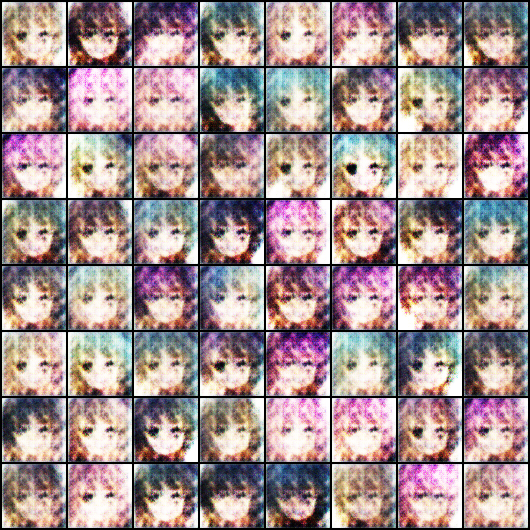

In [45]:
Image('./generated_anime/generated-images-0001.png')

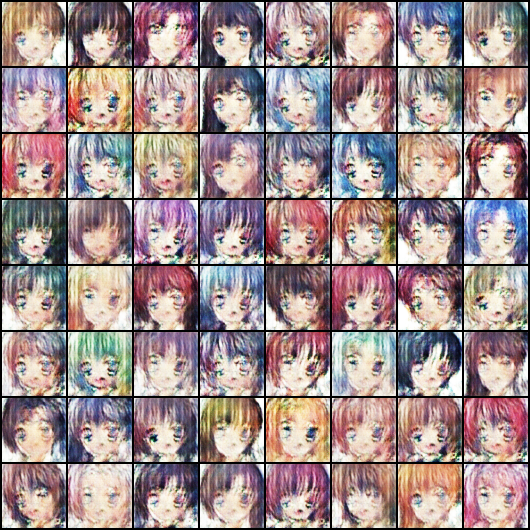

In [44]:
Image('./generated_anime/generated-images-0005.png')

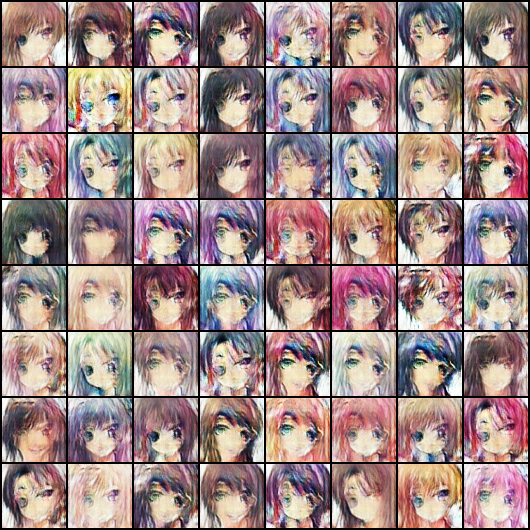

In [46]:
Image('./generated_anime/generated-images-0010.png')

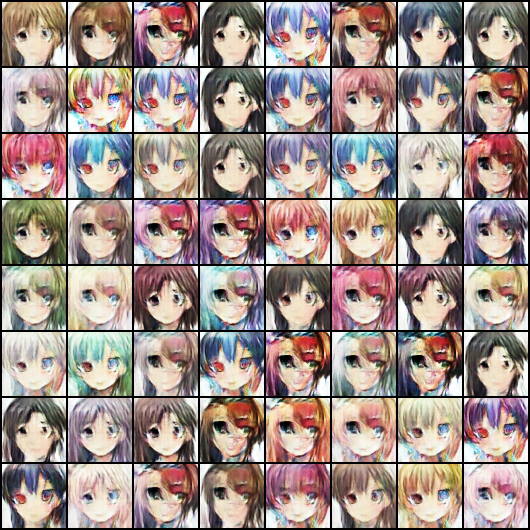

In [47]:
Image('./generated_anime/generated-images-0020.png')

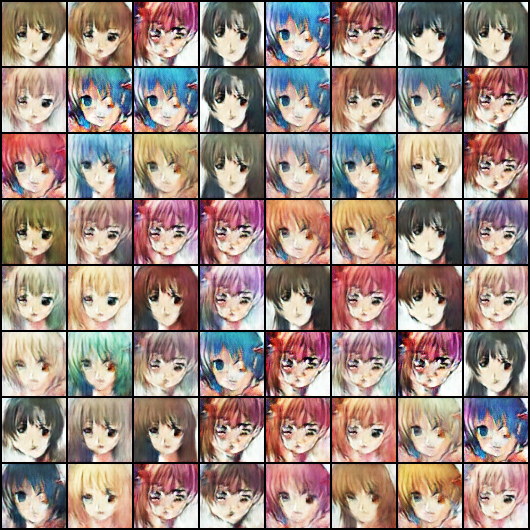

In [48]:
Image('./generated_anime/generated-images-0025.png')

In [49]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

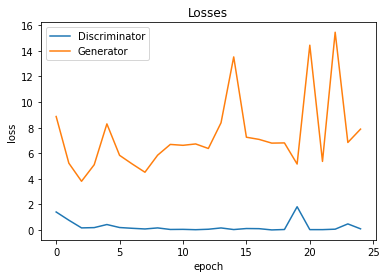

In [50]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

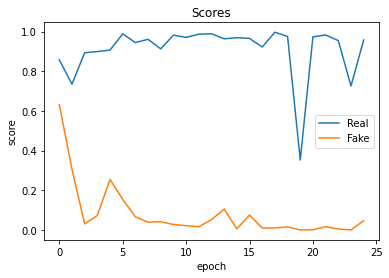

In [51]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [52]:
import jovian

In [53]:
jovian.commit(project=project_name, 
              outputs=['G.pth', 'D.pth', 'gans_training.avi'], 
              environment=None)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "gopirevathisreenivasan/06b-anime-dcgan" on https://jovian.ai/
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/gopirevathisreenivasan/06b-anime-dcgan


'https://jovian.ai/gopirevathisreenivasan/06b-anime-dcgan'